<h2>Notation</h2>

<ul>
<li>A -> State Transition Matrix</li>
<li>B -> Control Matrix</li>
<li>H -> Observation Matrix</li>
<li>Q -> Process Noise Covariance</li>
<li>R -> Measurement Noise Covariance</li>
<li>P -> Initial State Covariance Estimate</li>
<li>x0 -> Initial State Estimate</li>
</ul>

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter(object):
  def __init__(self, A = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):
    if(A is None or H is None):
      raise ValueError("Set proper system dynamics.")

    #Number of state variables
    self.n = A.shape[1]

    #Number of measurement variables
    self.m = H.shape[1]

    self.A = A
    self.H = H
    self.B = 0 if B is None else B

    #Covariance is often a diagonal matrix since variables are independent
    self.Q = np.eye(self.n) if Q is None else Q
    self.R = np.eye(self.n) if R is None else R
    self.P = np.eye(self.n) if P is None else P
    self.x = np.zeros((self.n, 1)) if x0 is None else x0

  def predict(self, u = 0):
    self.x = np.dot(self.A, self.x) + np.dot(self.B, u)
    self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
    return self.x

  def update(self, z):
    S = self.R + np.dot(self.H, np.dot(self.P, self.H.T)) # in parenthesees of inverse
    K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))

    y = z - np.dot(self.H, self.x) # in parenthesees of inverse
    self.x = self.x + np.dot(K, y)

    I = np.eye(self.n)
    self.P = np.dot(np.dot((I-np.dot(K,self.H)), self.P),((I-np.dot(K,self.H)).T))+np.dot(K,np.dot(self.R,K.T))
    return K

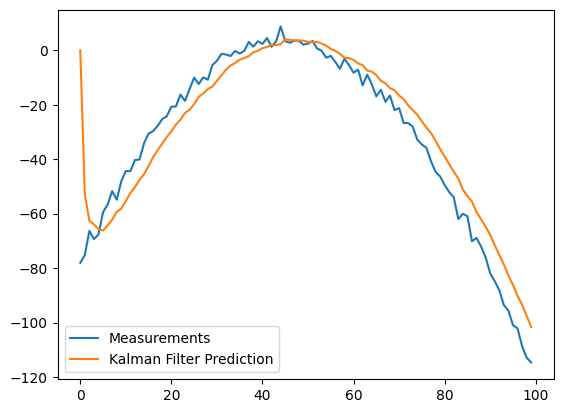

In [7]:
def example():
  A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
  H = np.array([1, 0, 0]).reshape(1, 3)
  Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
  R = np.array([0.5]).reshape(1, 1)

  x = np.linspace(-10, 10, 100)
  measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

  kf = KalmanFilter(A = A, H = H, Q = Q, R = R)
  predictions = []

  for z in measurements:
    predictions.append(np.dot(H,  kf.predict())[0])
    kf.update(z)

  plt.plot(range(len(measurements)), measurements, label = 'Measurements')
  plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
  plt.legend()
  plt.show()

if __name__ == '__main__':
    example()

This is another example where we have an object moving in 2d space with constant acceleration in both the x and y directions.

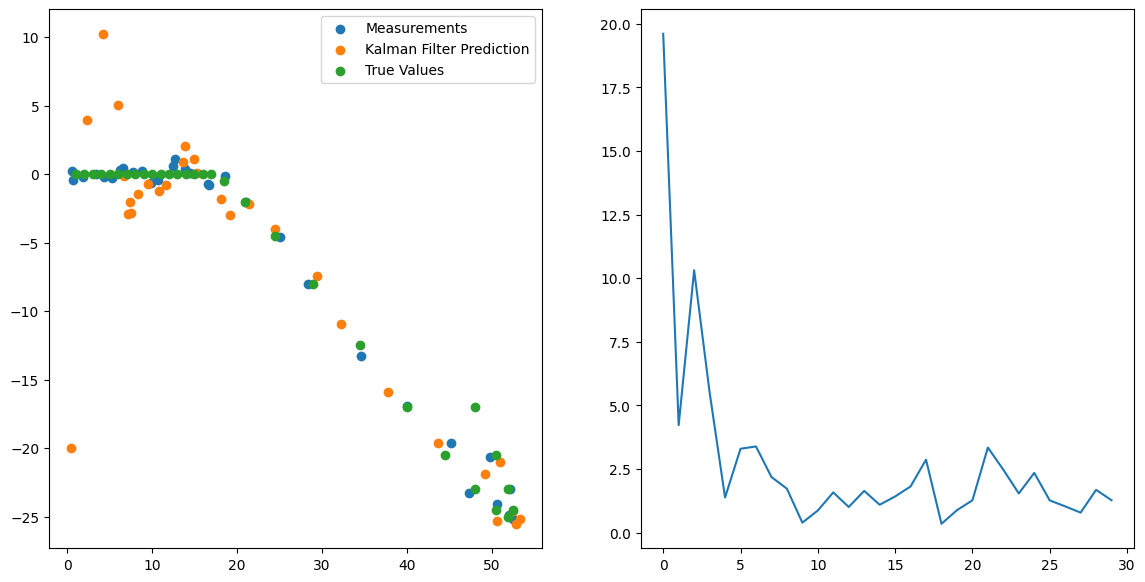

In [74]:
def example2(): #accelerating truck

    #A car moving in 2d with constant acceleration, variables are x, dx, d^2x, y, dy, d^2y and measurements are taken every second
    A = np.array([[1, 1, 0.5, 0, 0, 0], [0, 1, 1, 0, 0, 0],[0,0,1,0,0,0], [0, 0, 0, 1, 1, 0.5], [0,0,0,0,1,1],[0,0,0,0,0,1]])
    H = np.array([[1, 0, 0, 0, 0, 0],[0,0,0,1,0,0]])

    B = np.array([[0,0],[0,0],[1,0],[0,0],[0,0],[0,1]])

    Q = np.array([[0.1, 0, 0, 0, 0, 0], [0, 0.1, 0, 0, 0, 0],[0,0,0.1,0,0,0], [0, 0, 0, 0.1, 0, 0], [0,0,0,0,0.1,0],[0,0,0,0,0,0.1]])
    R = np.array([[1,0],[0,1]])

    x0 = np.array([[0,1,0,0,0,0]]).T
    x = np.array([[0,0,1,-20,0,0]]).T
    kf = KalmanFilter(A = A, B=B,H = H, Q = Q, R = R,x0=x)

    measure_var = 0.4
    z = (H @ x0)+np.random.normal([[0],[0]],measure_var, (2,1))

    truth = [A@x0]
    predictions = []
    measurements = [z]
    errors = []
    for i in range(30):
        if i == 15:
            u = np.array([[1],[-1]])
        elif i == 20:
            u = np.array([[-2],[2]])
        else:
            u = np.array([[0],[0]])
        x = np.dot(H,  kf.predict(u))
        predictions.append(x)
        z = np.dot(H,truth[-1])+np.random.normal([[0],[0]],measure_var, (2,1))
        truth.append(A@truth[-1]+B@u)
        measurements.append(z)
        errors.append(np.linalg.norm(x-z))
        K = kf.update(z)
    
    fig,axs = plt.subplots(1,2, figsize=(14, 7))
    axs[0].scatter([x[0][0] for x in measurements],[x[1][0] for x in measurements], label = 'Measurements')
    axs[0].scatter([x[0][0] for x in predictions],[x[1][0] for x in predictions], label = 'Kalman Filter Prediction')
    axs[0].scatter([(H@x)[0][0] for x in truth],[(H@x)[1][0] for x in truth], label = 'True Values')
    axs[0].legend()
    axs[1].plot([i for i in range(len(errors))],errors, label = 'Prediction vs Truth Error')
    plt.show()

if __name__ == '__main__':
    example2()